In [ ]:
from google.colab import drive
import numpy as np
import tensorflow as tf
import random
from tqdm import tqdm
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.image import imread
import math
from os import makedirs, listdir
from random import random, seed, shuffle
from shutil import copyfile
from keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Model, load_model
from keras.layers import Dense, Flatten
from keras.optimizers import SGD
from IPython.display import display
import ipywidgets as widgets
from google.colab import files
import io
from IPython.display import display
import os

In [ ]:
drive.mount('/content/drive')

image_dir = '/content/drive/My Drive/beeswasps/bees/'

for i, filename in enumerate(os.listdir(image_dir)):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        src = os.path.join(image_dir, filename)
        dst = os.path.join(image_dir, f'bee.{i+1}.jpg')
        os.rename(src, dst)

image_dir_wasps = '/content/drive/My Drive/beeswasps/wasps/'
for i, filename in enumerate(os.listdir(image_dir_wasps)):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        src = os.path.join(image_dir_wasps, filename)
        dst = os.path.join(image_dir_wasps, f'wasp.{i+1}.jpg')
        os.rename(src, dst)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Dataset Preperation
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


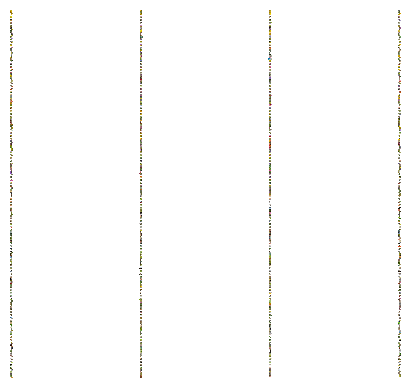

In [ ]:
print("Dataset Preperation")
drive.mount('/content/drive')
folder = {
    "bee":'/content/drive/My Drive/beeswasps/bees/',
    "wasp":'/content/drive/My Drive/beeswasps/wasps/'
}

total_images = 501
columns = 4
rows = math.ceil(total_images/columns)
total_rows = rows * len(folder)
subplot_index = 1

for label, folder in folder.items():
  for i in range (1, total_images +1 ):
    pyplot.subplot (total_rows, columns,subplot_index)
    filename= folder + f'{label}.{i}.jpg'
    try:
      image = imread(filename)
      pyplot.imshow(image)
      pyplot.axis('off')
    except FileNotFoundError:
      print(f"File not found: {filename}")
    subplot_index +=1

pyplot.show()

In [ ]:
dataset_home = 'dataset_bees_vs_wasps/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
  labeldirs = ['bees/', 'wasps/']
  for labeldir in labeldirs:
    newdir = dataset_home + subdir + labeldir
    makedirs(newdir, exist_ok=True)
seed (1)

val_ratio = 0.25

src_directories = {
    'wasps': '/content/drive/My Drive/beeswasps/wasps/',
    'bees': '/content/drive/My Drive/beeswasps/bees/'
}
for label, src_directory in src_directories.items():
  for file in listdir(src_directory):
    if file.startswith(label[:-1]):
            src = os.path.join(src_directory, file)
            dst_dir = 'train/' if random() >= val_ratio else 'test/'
            dst = os.path.join(dataset_home, dst_dir, label, file)
            copyfile(src, dst)

print("Dataset categorization complete!")

Dataset categorization complete!


In [ ]:
def define_model():
    model = VGG16(include_top= False, input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(1, activation='sigmoid')(class1)
    model = Model(inputs=model.inputs, outputs=output)
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def run_test_harness():
  model=define_model()
  datagen = ImageDataGenerator(featurewise_center=True)
  datagen.mean=[123.68, 116.779, 103.939]
  train_it = datagen.flow_from_directory('dataset_bees_vs_wasps/train/',
    class_mode='binary', batch_size=64, target_size=(224, 224))
  model.fit(train_it, steps_per_epoch=len(train_it), epochs=10, verbosSe=0)
  model.save('Mp1_model.h5')

run_test_harness()
print("CNN is successful!")


Found 774 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


CNN is successful!


In [ ]:
print("Finalizing Dataset")
dataset_home = 'dataset_bees_vs_wasps/'
labeldirs=['bees/', 'wasps/']

for labldir in labeldirs:
  newdir= dataset_home + labldir
  makedirs(newdir,exist_ok=True)

src_directory='dataset_bees_vs_wasps/train/'
for file in listdir(src_directory):
  if os.path.isfile(os.path.join(src_directory,file)):
    src = src_directory + '/' + file
    if file.startswith('bee'):
      dst=dataset_home + 'bees/' + file
      copyfile(src,dst)
    elif file.startswith('wasp'):
      dst=dataset_home + 'wasps/' + file
      copyfile(src,dst)
print("Finalizing Dataset Complete!")

Finalizing Dataset
Finalizing Dataset Complete!


In [ ]:
def evaluate_model():
    model = load_model('Mp1_model.h5')
    datagen = ImageDataGenerator(featurewise_center=True)
    datagen.mean = [123.68, 116.779, 103.939]
    test_it = datagen.flow_from_directory('dataset_bees_vs_wasps/test/',
                                          class_mode='binary', batch_size=64, target_size=(224, 224))
    _, accuracy = model.evaluate(test_it, steps=len(test_it), verbose=0)
    print('> %.3f' % (accuracy * 100.0))

evaluate_model()

Found 228 images belonging to 2 classes.
> 89.474


In [ ]:
def upload_and_predict():
    uploader = widgets.FileUpload(
        accept='image/*',
        multiple=False,
        description='Upload Image'
    )
    display(uploader)

    def handle_upload(change):
        uploaded_file = uploader.value
        if uploaded_file:
            uploaded_file = next(iter(uploaded_file.values()))
            content = uploaded_file['content']
            image = Image.open(io.BytesIO(content))
            image = image.resize((224, 224))

            img_array = img_to_array(image)
            img_array = img_array.reshape(1, 224, 224, 3)
            img_array = img_array.astype('float32')
            img_array = img_array - [123.68, 116.779, 103.939]

            model = load_model('Mp1_model.h5')

            result = model.predict(img_array)
            prediction = 'Wasp' if result[0] > 0.5 else 'Bee'
            confidence = result[0][0] * 100 if result[0] > 0.5 else (1 - result[0][0]) * 100

            print(f"Prediction: {prediction} ({confidence:.2f}%)")
            display(image)
    uploader.observe(handle_upload, names='value')

upload_and_predict()

print("Prediction Complete")

FileUpload(value={}, accept='image/*', description='Upload Image')

Prediction Complete
